In [1]:
import glob
from headtail.modules import bqht
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import cm
import numpy as np
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit
import matplotlib.gridspec as grd
import datetime

In [2]:
def prep_file(name):
    htf = ht.open_file(f'{name}')
    htf.locate_bunches()
    htf.optimise_overlap()
    htf.remove_baseline = False # Don't remove baseline
    htf.align = True            # Get aligned to the same X points
    return htf

In [3]:
# Create a new instance ands set the system to SPS
ht = bqht.BQHT(system='SPS')
# Select a file to use
dataDir = './h5_files/28May2018/'
files = sorted(glob.glob(dataDir+'/*.h5'))
print(files)

['./h5_files/28May2018/SPS.BQHT_HIRADMT2_20210930_142257.h5', './h5_files/28May2018/SPS.BQHT_LHC2_20180523_125613.h5', './h5_files/28May2018/SPS.BQHT_LHC2_20180523_170239.h5']


In [5]:
htf_0 = prep_file(files[0])  # stracture: htf_0.data.horizontal.delta[turns, bunches]['time', 'value']

In [6]:
Delta_H, Delta_V, Sigma = htf_0.horizontal.delta,  htf_0.vertical.delta, htf_0.vertical.sigma # Identical with htf_0.horizontal.sigma  

In [7]:
n_bunches = htf_0.horizontal.delta.number_of_bunches
n_populated_turns = htf_0.horizontal.delta.number_of_turns # the actual number is 5 (4 is the index)
n_slices = htf_0.horizontal.delta.samples_per_bunch # integer is used (round to lower number)
print(f'Bunhes {n_bunches}, Popoulated turns {n_populated_turns}, Slices {n_slices}')

Bunhes 924, Popoulated turns 215, Slices 249.5887445887446


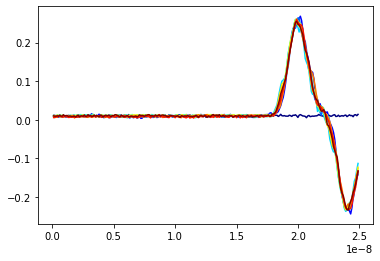

In [8]:
bunch = 0
fig, ax = plt.subplots()
colors = mpl.cm.jet(np.linspace(0, 1, 10)) 
for turn in range(10):
    x  = Sigma[turn, bunch][0]  # 0 --> 'time'
    y = Sigma[turn, bunch][1] # 1 --> 'value'
    ax.plot(x, y, color=colors[turn])
#ax.set_xlim(1.1e-8, 1.5e-8)
#ax.set_xlim(0.5e-8, 0.7e-8)

(2e-09, 1.3e-08)

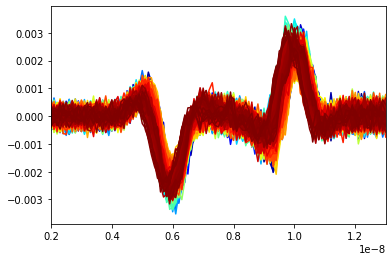

In [15]:
bunch = 0
fig, ax = plt.subplots()
colors = mpl.cm.jet(np.linspace(0, 1, 1000)) 

turns_list = np.linspace(13000, 14000, 1000)
for i, turn in enumerate(turns_list):
    turn = int(turn)
    x  = Delta_V[turn, bunch][0]  # 0 --> 'time'
    y = Delta_V[turn, bunch][1] # 1 --> 'value'
    ax.plot(x, y, color=colors[i])
ax.set_xlim(0.2e-8, 1.3e-8)
#ax.set_xlim(0.5e-8, 0.7e-8)

In [20]:
x_list, t_list = [], []
turns_list = np.linspace(0, n_populated_turns, n_populated_turns, dtype=int)

for turn in turns_list:    
    t_list.append(Delta_V[int(turn), bunch][0])
    x_list.append(Delta_V[int(turn), bunch][1])
    

(0, 10000)

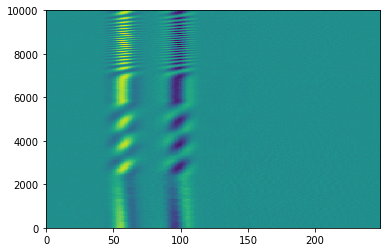

In [46]:
fig, ax = plt.subplots() # 
ax.imshow(x_list,  aspect='auto')

ax.set_ylim(0, n_populated_turns)
ax.set_ylim(0, 10000)
#ax.set_ylim(7500, 8500)
#ax.set_ylim(19000, 20000)

#ax.set_ylim(28000, 20000)

In [ ]:
# baseline: first part of the cycle. CC not synchronised with the main RF

In [24]:
def calc_means(htf, N):
    pts = int(htf.horizontal.sigma.samples_per_bunch) # slices
    M = int(htf.horizontal.sigma.number_of_turns/N)
    print(M)
    means_delta = []
    means_sigma = []
    for i in range(N):
        mean_delta = np.zeros(pts)
        mean_sigma = np.zeros(pts)
        for j in range(M):
            x, y = htf.vertical.sigma[i*M+j,0]
            mean_sigma += y
            x, y = htf.vertical.delta[i*M+j,0]
            mean_delta += y
        mean_delta /= M
        mean_sigma /= M
        means_delta.append(mean_delta)
        means_sigma.append(mean_sigma)
    return (np.array(means_sigma), np.array(means_delta))

In [25]:
sigma_0, delta_0 = calc_means(htf_0, N=2) # mean over 100 turns. N matters

20000


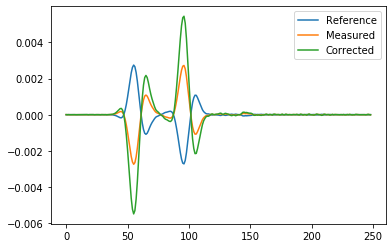

In [28]:
plt.plot(delta_0[0], label='Reference')
plt.plot(delta_0[1], label='Measured')
plt.plot(delta_0[1]-delta_0[0], label='Corrected')
plt.legend()

In [48]:
n_reference_turns = 10000
x_list_ref = x_list[:n_reference_turns]
x_list_measured = x_list[n_reference_turns:]

mean_delta_ref = np.mean(x_list_ref, axis=0)
mean_delta_measured = np.mean(x_list_measured, axis=0)

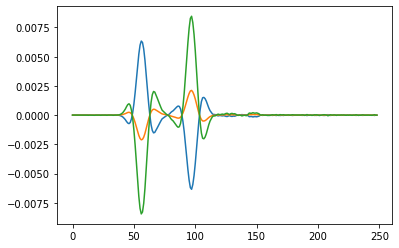

In [51]:
plt.plot(mean_delta_ref)
plt.plot(mean_delta_measured)
plt.plot(mean_delta_measured-mean_delta_ref)

In [ ]:
# Plot sigma and delta in 2D.
# Like in slide 4: https://indico.cern.ch/event/826475/contributions/3457525/attachments/1872464/3081710/2019-07-02_HL_WP2_tlevens.pdf

In [125]:
n_bunches = htf_0.horizontal.delta.number_of_bunches
n_populated_turns = htf_0.horizontal.delta.number_of_turns # the actual number is 5 (4 is the index)
n_slices = htf_0.horizontal.delta.samples_per_bunch # integer is used (round to lower number)
print(n_populated_turns, n_bunches, n_slices)

40000 4 249.5887445887446


(5e-09, 7e-09)

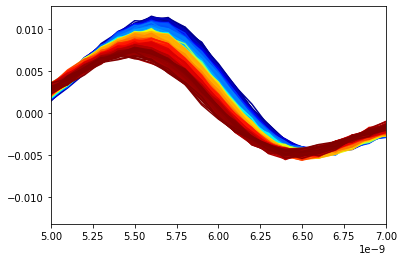

In [333]:
fig, ax = plt.subplots()
colors = mpl.cm.jet(np.linspace(0, 1, 1000)) 
for turn in range(1000):
    x  = htf_0.vertical.delta[turn, bunch][0]  # 0 --> 'time'
    y = htf_0.vertical.delta[turn, bunch][1] # 1 --> 'value'
    ax.plot(x, y, color=colors[turn])
ax.set_xlim(0, 1.5e-8)
ax.set_xlim(0.5e-8, 0.7e-8)

(5e-09, 7e-09)

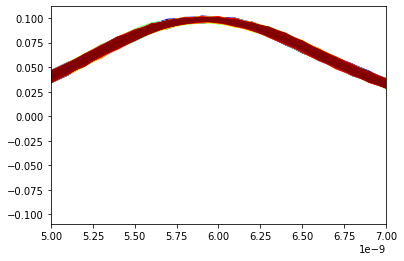

In [470]:
fig, ax = plt.subplots()
colors = mpl.cm.jet(np.linspace(0, 1, 2000)) 
for turn in range(2000):
    x  = htf_0.vertical.sigma[turn, bunch][0]  # 0 --> 'time'
    y = htf_0.vertical.sigma[turn, bunch][1] # 1 --> 'value'
    ax.plot(x, y, color=colors[turn])
ax.set_xlim(0, 1.5e-8)
ax.set_xlim(0.5e-8, 0.7e-8)

0.0004846979
0.0004846979
0.0001475152
0.0001475152


(5e-09, 7e-09)

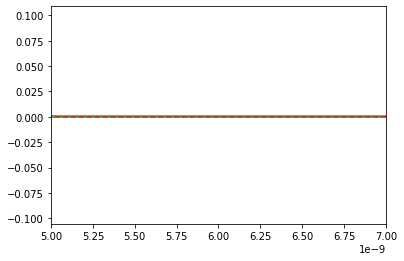

In [477]:
fig, ax = plt.subplots()
colors = mpl.cm.jet(np.linspace(0, 1, 2)) 
for turn in range(2):
    x  = htf_0.horizontal.sigma[turn, bunch][1]  # 0 --> 'time'
    y = htf_0.vertical.sigma[turn, bunch][1] # 1 --> 'value'
    print(x[0])
    print(y[0])
    ax.plot(y)
    ax.plot(x, ls='--')
ax.set_xlim(0, 1.5e-8)
ax.set_xlim(0.5e-8, 0.7e-8)


In [434]:
def calc_means(htf, N):
    pts = int(htf.horizontal.sigma.samples_per_bunch) # slices
    M = int(htf.horizontal.sigma.number_of_turns/N)
    print(M)
    means_delta = []
    means_sigma = []
    for i in range(N):
        mean_delta = np.zeros(pts)
        mean_sigma = np.zeros(pts)
        for j in range(M):
            x, y = htf.vertical.sigma[i*M+j,0]
            mean_sigma += y
            x, y = htf.vertical.delta[i*M+j,0]
            mean_delta += y
        mean_delta /= M
        mean_sigma /= M
        means_delta.append(mean_delta)
        means_sigma.append(mean_sigma)
    return (np.array(means_sigma), np.array(means_delta))

In [435]:
sigma_0, delta_0 = calc_means(htf_0, N=2) # mean over 100 turns. N matters

20000


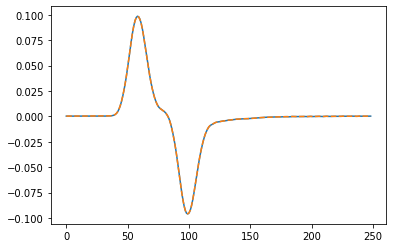

In [441]:
plt.plot(sigma_0[0])
plt.plot(sigma_0[1], ls='--')

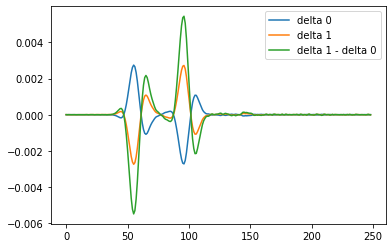

In [452]:
plt.plot(delta_0[0], label='delta 0')
plt.plot(delta_0[1], label='delta 1')
plt.plot(delta_0[-1]-delta_0[0], label='delta 1 - delta 0')
plt.legend()

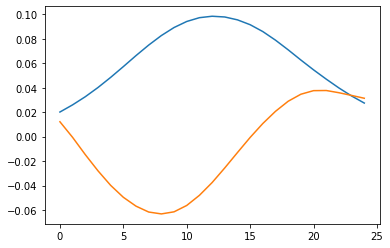

In [468]:
mid = np.argmax(sigma_0[-1]) # identical result for np.argmax(sigma[0])
a = mid - 12
b = mid + 13
x = np.arange(-1.2, 1.3, 0.1)
#plt.plot(x, sigma_0[-1][a:b])
plt.plot(sigma_0[-1][a:b])
signal = (delta_0[-1] - delta_0[0])[a:b] / sigma_0[-1][a:b]
plt.plot(signal)

In [ ]:
sigma

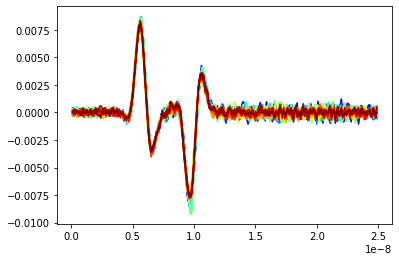

In [431]:
fig, ax = plt.subplots()
colors = mpl.cm.jet(np.linspace(0, 1, 40)) 
for turn in range(40):
    x  = htf_0.vertical.delta[turn, bunch][0] # 0 --> 'time'
    y = htf_0.vertical.delta[turn, bunch][1]-delta_0[0] # 1 --> 'value'
    ax.plot(x, y, color=colors[turn])
#ax.set_xlim(1.3e-8, 1.6e-8)
#ax.set_xlim(0.5, )
#ax.set_ylim(-0.003, 0.003)

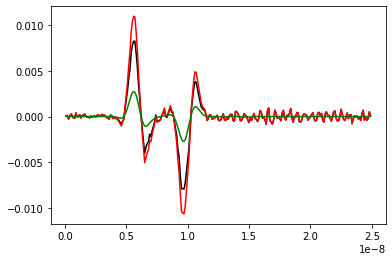

In [433]:
fig, ax = plt.subplots()
colors = mpl.cm.jet(np.linspace(0, 1, 40000))
turns_list= list(range(40000))

for turn in turns_list[1:2]:
    x  = htf_0.vertical.delta[turn, bunch][0] # 0 --> 'time'
    y = htf_0.vertical.delta[turn, bunch][1]-delta_0[0] # 1 --> 'value'
    y2 = htf_0.vertical.delta[turn, bunch][1] # 1 --> 'value'
    y3 = delta_0[0] # 1 --> 'value'

   
    ax.plot(x, y, color='k')
    ax.plot(x, y2, color='r')
    ax.plot(x, y3, color='g')
    
#ax.set_xlim(0.5e-8, 0.7e-8)
#ax.set_xlim(0.5, )
#ax.set_ylim(-0.003, 0.003)

In [420]:
def getHTtraces(sigma, delta):
    
    mid = np.argmax(sigma[-1])
    a = mid - 12
    b = mid + 13

    #plot(x, sigma[-1][a:b] * 8 - 0.4, c=color, ls=linestyle)
    #calculate amplitude scaling factor to ensure result is in MV (from mm)

    normPositionFactor = 0.1052 #This factor comes from T. Levens and was measured in 2017
    amp_factor = 1/(normPositionFactor)      #1e-6 is for V to MV
    
    signal = (delta[-1] - delta[0])[a:b] / sigma[-1][a:b] # Dividing delta signal (with subtracted baseline) with sum signal gives intra-bunch offset
    return signal*amp_factor, sigma[-1][a:b]

In [421]:
crabwave, sigma = getHTtraces(sigma_0, delta_0)

IndexError: invalid index to scalar variable.

In [382]:
x = np.arange(-1.2, 1.3, 0.1) # why?

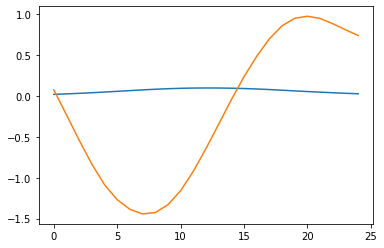

In [383]:
plt.plot(sigma)
plt.plot(crabwave)

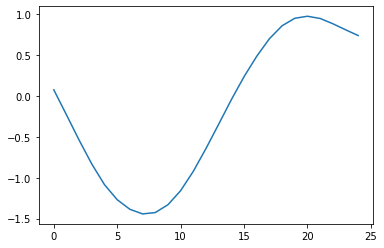

In [384]:
x = np.arange(-1.2, 1.3, 0.1)
crabInterp = interp1d(x, crabwave, bounds_error=False, fill_value=0)
plt.plot(crabInterp(x))

In [385]:
def getOrbitResponse():
    # Bring in relevant optics parameters to calculate orbit response
    # at location of HT monitor from CC kick

    PAY = 8.230968*(2*np.pi) #Slide 16 of Hannes' JUAS # maybe you want to cross check this with madx
    beta_cc = 64.776662
    beta_ht = 49.434524
    total_Q = 26.18

    orbitResponse1 = np.sqrt(beta_ht)/(2*np.sin(np.pi*total_Q)) #slide 42 of Hannes' JUAS
    orbitResponse2 = np.sqrt(beta_cc)*np.cos(np.pi*total_Q - PAY)
    orbitResponse = orbitResponse1*orbitResponse2
    return orbitResponse

In [386]:
orbitResponse = getOrbitResponse()

In [387]:
def gauss(x, *p):
    A, mu, sigma = p
    return A*np.exp(-(x-mu)**2/(2.*sigma**2))

In [388]:
p0 = [2000., 0., 0.18] # where does the 2000 come from??? or the 0.18 etc
coeff, var_matrix = curve_fit(gauss, x, sigma, p0=p0)

In [389]:
def varFunc(y,z):
    return yGauss(y)*gauss(z, coeff[0], coeff[1], coeff[2])


def yGauss(x): #Take the measured profile in z. Assume a Gaussian profile in y with sigma taken from wirescan
    sig = 2.22 #mm # what is this 2.22 [mm] from WS
    intensity = 1
    return intensity/(sig*np.sqrt(2*np.pi))*np.exp(-x*x/(2*sig*sig)) # fot color bar? intensity according to the sum of the signal

In [390]:
yvals = np.arange(-6,6,0.1)
zvals = x
yy,zz = np.meshgrid(yvals,zvals)

# Modulate in z with intra-bunch offset
aa = varFunc(yy-crabInterp(zz),zz)/(np.trapz(gauss(zvals, coeff[0], coeff[1], coeff[2]),x=zvals))


In [391]:
def unix2string(f):
    return datetime.datetime.fromtimestamp(int(f)).strftime('%Y-%m-%d %H:%M:%S.%f')


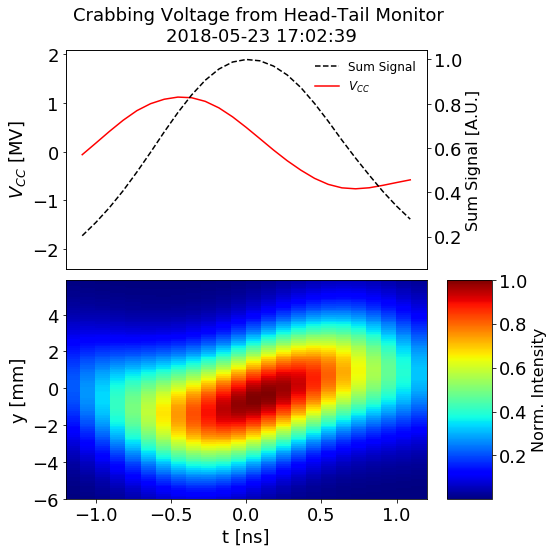

In [392]:
fig = plt.figure(figsize=(8,8))
gs = grd.GridSpec(2, 2, height_ratios=[10,10], width_ratios=[8,1], wspace=0.1)
ax1 = plt.subplot(gs[2])
cax = ax1.pcolormesh(zz, yy, aa/np.amax(aa), cmap = cm.jet)

colorax = plt.subplot(gs[3])
cbar = plt.colorbar(cax, cax=colorax)
cbar.set_label('Norm. Intensity', fontsize=16)
colorax.tick_params(axis='both', labelsize=18)
    
ax2 = plt.subplot(gs[0])
#ax2.plot(zvals, -crabwave*26e9/(orbitResponse*1e9), color='r')
ax2.plot(zvals, -crabwave*26e9/(orbitResponse*1e9), color='r')
    
ax2.axes.get_xaxis().set_visible(False)
ax22 = ax2.twinx()
ax22.plot(x, sigma/np.amax(sigma), color='k', linestyle='dashed', label='Sum Signal')
ax22.set_ylabel('Sum Signal [A.U.]', fontsize=16)
ax22.tick_params(axis='both', which='both', labelsize=18)
ax22.plot([0],[0.1],color='r', label=r'$V_{CC}$')
ax22.legend(loc=1, frameon=False, fontsize=12)
#ax22.set_ylim([0,1])


ax2.set_ylim(-2.4,2.1)
ax1.set_xlabel('t [ns]', fontsize=18)
ax1.set_ylabel('y [mm]', fontsize=18)
ax2.set_ylabel(r'$V_{CC}\ \mathrm{[MV]}$', fontsize=18)
ax1.tick_params(axis='both', which='both', labelsize=18)
ax2.tick_params(axis='both', which='both', labelsize=18)
fig.subplots_adjust(left=0.16, hspace=0.05, top=0.905)
plt.suptitle('Crabbing Voltage from Head-Tail Monitor \n' + unix2string(htf_0.acq_stamp/1e9)[:-7], fontsize=18)
plt.savefig(unix2string(htf_0.acq_stamp/1e9)[11:-7].replace(':','')+'.png')
plt.show()


In [124]:
bunch = range(n_bunches)[0] 
print(f'Selected bunch for the current analysis: {bunch}')

Selected bunch for the current analysis: 0


In [ ]:
# Iterate over the planes (horizontal/vertical) and signals (sigma/delta)
for ax, (plane, signal) in zip(axes, htf_0.planes_signals):
    # Get the data for this plane/signal
    # You can also use the syntax htf.data.horizontal.delta (for example)
    # but it is less convenient if you have the plane/signal as strings
    data = htf.data[plane][signal]
 
        # Jet is the greatest colour map :-)
        colors = mpl.cm.jet(np.linspace(0, 1, data.number_of_turns)) # the color code indicates the number of turns
 
        # Iterate over the turns
        for turn in htf.populated_turns:
            x, y = data[turn, bunch]
 
            # Finally plot it
            ax.plot(x, y, color=colors[turn])

In [46]:
colors = mpl.cm.jet(np.linspace(0, 1, n_populated_turns)) 

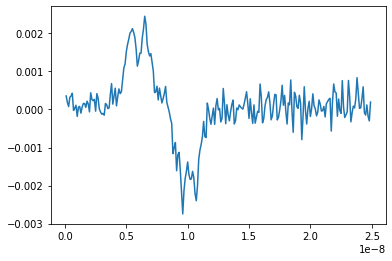

In [94]:
turn = 0
x = htf_0.horizontal.delta[turn, bunch][0] # 0 --> 'time'
y = htf_0.horizontal.delta[turn, bunch][1] # 1 --> 'value'
plt.plot(x, y)

IndexError: turn must be an integer

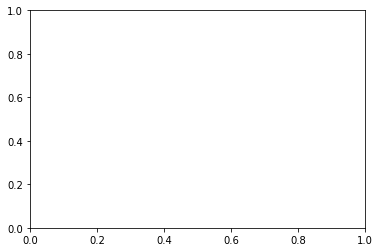

In [84]:
x_list, y_list = [], [] 

for turn in range(n_populated_turns):
    x_list.append(htf_0.horizontal.delta[turn, bunch][0])  # 0 --> 'time'
    y_list.append(htf_0.horizontal.delta[turn, bunch][1]) # 1 --> 'value'
    ax.plot(x, y, color=colors[turn])

In [6]:
htf = ht.open_file(f'{name}')

In [7]:
htf.locate_bunches()

In [8]:
htf.optimise_overlap()

In [11]:
htf.align = True
htf.remove_baseline = False # Don't remove baseline

In [18]:
htf.data.horizontal.delta#[turn, bunch][time, value]

(array([2.5000000e-08, 2.5100000e-08, 2.5200000e-08, 2.5300000e-08,
        2.5400000e-08, 2.5500000e-08, 2.5600000e-08, 2.5700000e-08,
        2.5800000e-08, 2.5900000e-08, 2.6000000e-08, 2.6100000e-08,
        2.6200000e-08, 2.6300000e-08, 2.6400000e-08, 2.6500000e-08,
        2.6600000e-08, 2.6700000e-08, 2.6800000e-08, 2.6900000e-08,
        2.7000000e-08, 2.7100000e-08, 2.7200000e-08, 2.7300000e-08,
        2.7400000e-08, 2.7500000e-08, 2.7600001e-08, 2.7700001e-08,
        2.7800001e-08, 2.7900001e-08, 2.8000001e-08, 2.8100001e-08,
        2.8200001e-08, 2.8300001e-08, 2.8400001e-08, 2.8500001e-08,
        2.8600001e-08, 2.8700001e-08, 2.8800001e-08, 2.8900001e-08,
        2.9000001e-08, 2.9100001e-08, 2.9200001e-08, 2.9300001e-08,
        2.9400001e-08, 2.9500001e-08, 2.9600001e-08, 2.9700001e-08,
        2.9800001e-08, 2.9900001e-08, 2.9999999e-08, 3.0100001e-08,
        3.0199999e-08, 3.0300001e-08, 3.0399999e-08, 3.0500001e-08,
        3.0599999e-08, 3.0700001e-08, 3.0799999e

In [2]:
# Create a new instance ands set the system to SPS
ht = bqht.BQHT(system='SPS')
# Select a file to use
dataDir = './h5_files/28May2018/'
files = sorted(glob.glob(dataDir+'/*.h5'))

In [3]:
def prep_file(name):
    htf = ht.open_file(f'{name}')
    htf.locate_bunches()
    htf.optimise_overlap()
    n_bunches = htf.bunches
    n_popultated_turns = htf.populated_turns # Evaluated turns which contain meaningful signals
    
    for p, s in htf.planes_signals:
        htf[p][s].remove_baseline = False # Don't remove baseline
        htf[p][s].align = True            # Get aligned to the same X points
    return htf, n_bunches, n_popultated_turns

In [4]:
htf_0, n_bunches, n_popultated_turns = prep_file(files[0])  

In [13]:

htf_0.horizontal.delta[0]

(array([1.0000000e-10, 2.0000000e-10, 3.0000000e-10, ..., 1.2450000e-07,
        1.2460001e-07, 1.2470001e-07], dtype=float32),
 array([5.2138674e-04, 3.5201877e-04, 2.4242776e-04, ..., 4.6492307e-05,
        1.8929271e-04, 2.9887597e-05], dtype=float32))

In [14]:

htf_0.horizontal.delta[1]

(array([1.0000000e-10, 2.0000000e-10, 3.0000000e-10, ..., 1.2450000e-07,
        1.2460001e-07, 1.2470001e-07], dtype=float32),
 array([ 3.3200786e-06, -2.0589915e-04,  7.3059811e-05, ...,
         4.3171371e-05, -1.2287564e-04,  3.3200777e-06], dtype=float32))

In [33]:

htf_0.horizontal.delta.number_of_bunches

4

In [23]:
len(n_popultated_turns)

40000